In [1]:
import numpy as np
import diffrax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import equinox as eqx

jax.config.update("jax_enable_x64", True)

In [12]:
class true_model_kholodenko(eqx.Module):
    def __call__(self, t, y, args):
        # unpack state
        MKKK_P, MKK_P, MKK_PP, MAPK_P, MAPK_PP = y
        
        # unpack parameters
        v1,KI,K1,n,v2,K2,k3,K3,k4,K4,v5,K5,v6,K6,k7,K7,k8,K8,v9,K9,v10,K10, \
            MKKK_total, MKK_total, MAPK_total = args

        # algebraic equations
        MKKK = MKKK_total - MKKK_P  # MKKK
        MKK = MKK_total - MKK_P - MKK_PP  # MKK
        MAPK = MAPK_total - MAPK_P - MAPK_PP  # MAPK
        
        # fluxes
        J1 = (v1*MKKK)/((1+(MAPK_PP/KI)**n)*(K1 + MKKK))
        J2 = (v2*MKKK_P)/(K2 + MKKK_P)
        J3 = (k3*MKKK_P*MKK)/(K3 + MKK)
        J4 = (k4*MKKK_P*MKK_P)/(K4 + MKK_P)
        J5 = (v5*MKK_PP)/(K5 + MKK_PP)
        J6 = (v6*MKK_P)/(K6 + MKK_P)
        J7 = (k7*MKK_PP*MAPK)/(K7 + MAPK)
        J8 = (k8*MKK_PP*MAPK_P)/(K8 + MAPK_P)
        J9 = (v9*MAPK_PP)/(K9 + MAPK_PP)
        J10 = (v10*MAPK_P)/(K10 + MAPK_P)

        # ODE rhs
        # d_MKKK = J2 - J1
        d_MKKK_P = J1 - J2
        # d_MKK = J6 - J3
        d_MKK_P = J3 + J5 - J4 - J6
        d_MKK_PP = J4 - J5
        # d_MAPK = J10 - J7
        d_MAPK_P = J7 + J9 - J8 - J10
        d_MAPK_PP = J8 - J9

        # concatenate into tuple and return
        return (d_MKKK_P, d_MKK_P, d_MKK_PP, d_MAPK_P, d_MAPK_PP)
    
# define nominal parameter values
v1_true = 2.5
KI_true = 9.0
K1_true = 10.0
n_true= 1.0
v2_true = 0.25
K2_true = 8.0
k3_true = 0.025
K3_true = 15.0
k4_true = 0.025
K4_true = 15.0
v5_true = 0.75
K5_true = 15.0
v6_true = 0.75
K6_true = 15.0
k7_true = 0.025
K7_true = 15.0
k8_true = 0.025
K8_true = 15.0
v9_true = 0.5
K9_true = 15.0
v10_true = 0.5
K10_true = 15.0
MKKK_total_true = 100
MKK_total_true = 300
MAPK_total_true = 300

# define initial conditions
MKKK_P_0_true = 90
MKK_P_0_true = 10
MKK_PP_0_true = 0
MAPK_P_0_true = 10
MAPK_PP_0_true = 0

In [13]:
true_model = diffrax.ODETerm(true_model_kholodenko())
solver = diffrax.Kvaerno5()
stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-6)
t0 = 0.0
t1 = 300 # minutes
dt0 = 1e-3
times = np.arange(t0, t1, 2)
saveat = saveat=diffrax.SaveAt(ts=times)
y0_true = (MKKK_P_0_true, MKK_P_0_true, MKK_PP_0_true, MAPK_P_0_true, MAPK_PP_0_true)
params_true = (v1_true, KI_true, K1_true, n_true, v2_true, K2_true, k3_true, 
          K3_true, k4_true, K4_true, v5_true, K5_true, v6_true, K6_true, 
          k7_true, K7_true, k8_true, K8_true, v9_true, K9_true, v10_true, 
          K10_true, MKKK_total_true, MKK_total_true, MAPK_total_true)

sol_true = diffrax.diffeqsolve(
    true_model, 
    solver, 
    t0, t1, dt0, 
    y0_true, 
    saveat=saveat, stepsize_controller=stepsize_controller,
    args=params_true)

rng = np.random.default_rng(seed=42)
sigma = 10
subsample = 5
sub_mapk_pp = sol_true.ys[-1][:-1:subsample]
sub_time = sol_true.ts[:-1:subsample]
noise = rng.normal(size=sub_mapk_pp.shape) * sigma

In [17]:
class model_1_noFeedback(eqx.Module):
    def __call__(self, t, y, args):
        # unpack state
        MKKK_P, MKK_P, MKK_PP, MAPK_P, MAPK_PP = y
        
        # unpack parameters
        v1,K1,v2,K2,k3,K3,k4,K4,v5,K5,v6,K6,k7,K7,k8,K8,v9,K9,v10,K10,\
            MKKK_total,MKK_total,MAPK_total = args

        # algebraic equations
        MKKK = MKKK_total - MKKK_P  # MKKK
        MKK = MKK_total - MKK_P - MKK_PP  # MKK
        MAPK = MAPK_total - MAPK_P - MAPK_PP  # MAPK
        
        # fluxes
        J1 = (v1*MKKK)/(K1 + MKKK)
        J2 = (v2*MKKK_P)/(K2 + MKKK_P)
        J3 = (k3*MKKK_P*MKK)/(K3 + MKK)
        J4 = (k4*MKKK_P*MKK_P)/(K4 + MKK_P)
        J5 = (v5*MKK_PP)/(K5 + MKK_PP)
        J6 = (v6*MKK_P)/(K6 + MKK_P)
        J7 = (k7*MKK_PP*MAPK)/(K7 + MAPK)
        J8 = (k8*MKK_PP*MAPK_P)/(K8 + MAPK_P)
        J9 = (v9*MAPK_PP)/(K9 + MAPK_PP)
        J10 = (v10*MAPK_P)/(K10 + MAPK_P)

        # ODE rhs
        # d_MKKK = J2 - J1
        d_MKKK_P = J1 - J2
        # d_MKK = J6 - J3
        d_MKK_P = J3 + J5 - J4 - J6
        d_MKK_PP = J4 - J5
        # d_MAPK = J10 - J7
        d_MAPK_P = J7 + J9 - J8 - J10
        d_MAPK_PP = J8 - J9

        # concatenate into tuple and return
        return (d_MKKK_P, d_MKK_P, d_MKK_PP, d_MAPK_P, d_MAPK_PP)
    
# define nominal parameter values
v1_m1 = 2.5
K1_m1 = 10.0
v2_m1 = 0.25
K2_m1 = 8.0
k3_m1 = 0.025
K3_m1 = 15.0
k4_m1 = 0.025
K4_m1 = 15.0
v5_m1 = 0.75
K5_m1 = 15.0
v6_m1 = 0.75
K6_m1 = 15.0
k7_m1 = 0.025
K7_m1 = 15.0
k8_m1 = 0.025
K8_m1 = 15.0
v9_m1 = 0.5
K9_m1 = 15.0
v10_m1 = 0.5
K10_m1 = 15.0
MKKK_total_m1 = 100
MKK_total_m1 = 300
MAPK_total_m1 = 300

# define initial conditions
MKKK_P_0_m1 = 90
MKK_P_0_m1 = 10
MKK_PP_0_m1 = 0
MAPK_P_0_m1 = 10
MAPK_PP_0_m1 = 0

In [19]:
model_1 = diffrax.ODETerm(model_1_noFeedback())
y0_m1 = (MKKK_P_0_m1, MKK_P_0_m1, MKK_PP_0_m1, MAPK_P_0_m1, MAPK_PP_0_m1)
params_m1 = (v1_m1, K1_m1, v2_m1, K2_m1, k3_m1, K3_m1, k4_m1, K4_m1, v5_m1, 
          K5_m1, v6_m1, K6_m1, k7_m1, K7_m1, k8_m1, K8_m1, v9_m1, K9_m1, v10_m1, 
          K10_m1, MKKK_total_m1, MKK_total_m1, MAPK_total_m1)

sol_model_1 = diffrax.diffeqsolve(
    model_1, 
    solver, 
    t0, t1, dt0, 
    y0_m1, 
    saveat=saveat, stepsize_controller=stepsize_controller,
    args=params_m1)

In [68]:
class model_2_Huang_Ferrell(eqx.Module):
    def __call__(self, t, y, args):
        # unpack state
        MKKK_E1, MKKK_P, MKKK_P_E2, MKK_MKKK_P, MKK_P, \
        MKK_P_MKKPase, MKK_P_MKKK_P, MKK_PP, MKK_PP_MKKPase, \
        MAPK_MKK_PP, MAPK_P, MAPK_P_MAPKPase, MAPK_P_MKK_PP, MAPK_PP, \
        MAPK_PP_MAPKPase = y

        # MKKK, MKKK_E1, MKKK_P, MKKK_P_E2, MKK, MKK_MKKK_P, MKK_P, \
        # MKK_P_MKKPase, MKK_P_MKKK_P, MKK_PP, MKK_PP_MKKPase, MAPK, \
        # MAPK_MKK_PP, MAPK_P, MAPK_P_MAPKPase, MAPK_P_MKK_PP, MAPK_PP, \
        # MAPK_PP_MAPKPase = y
        
        # unnpack parameters
        a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,\
        d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,\
        k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,\
        E1_tot,E2_tot,MKKK_tot,MKK_tot,MAPK_tot,MKKPase_tot,MAPKPase_tot = args

        MKKK = MKKK_tot - MKKK_P - MKKK_E1 - MKKK_P_E2
        MKK = MKK_tot - MKK_P - MKK_PP - MKK_MKKK_P - MKK_P_MKKK_P - MKK_P_MKKPase - MKK_PP_MKKPase - MAPK_MKK_PP - MAPK_P_MKK_PP
        MAPK = MAPK_tot - MAPK_P - MAPK_PP - MAPK_MKK_PP - MAPK_P_MKK_PP - MAPK_P_MAPKPase - MAPK_PP_MAPKPase
        MKKPase = MKKPase_tot - MKK_P_MKKPase - MKK_PP_MKKPase
        MAPKPase = MAPKPase_tot - MAPK_P_MAPKPase + MAPK_PP_MAPKPase
        E1 = E1_tot - MKKK_E1
        E2 = E2_tot - MKKK_P_E2

        # define fluxes
        J1 = a1*MKKK*E1
        J2 = d1*MKKK_E1
        J3 = k2*MKKK_P_E2
        J4 = k1*MKKK_E1
        J5 = a2*MKKK_P*E2
        J6 = d2*MKKK_P_E2
        J7 = k3*MKK_MKKK_P
        J8 = d3*MKK_MKKK_P
        J9 = a3*MKKK_P*MKK
        J10 = k5*MKK_P_MKKK_P
        J11 = d5*MKK_P_MKKK_P
        J12 = a5*MKK_P*MKKK_P
        J13 = k4*MKK_P_MKKPase
        J14 = a4*MKK_P*MKKPase
        J15 = d4*MKK_P_MKKPase
        J16 = k6*MKK_PP_MKKPase
        J17 = a6*MKK_PP*MKKPase
        J18 = d6*MKK_PP_MKKPase
        J19 = a7*MKK_PP*MAPK
        J20 = d7*MAPK_MKK_PP
        J21 = k7*MAPK_MKK_PP
        J22 = d9*MAPK_P_MKK_PP
        J23 = k9*MAPK_P_MKK_PP
        J24 = a9*MAPK_P*MKK_PP
        J25 = k8*MAPK_P_MAPKPase
        J26 = a8*MAPK_P*MAPKPase
        J27 = d8*MAPK_P_MAPKPase
        J28 = k10*MAPK_PP_MAPKPase
        J29 = a10*MAPK_PP*MAPKPase
        J30 = d10*MAPK_PP_MAPKPase

        # ODE rhs
        # d_MKKK = J2 + J3 - J1
        d_MKKK_E1 = J1 -  J2 - J4
        d_MKKK_P = -J5 + J6 + J4 + J7 + J8 - J9 + J10 + J11 - J12
        d_MKKK_P_E2 = J5 - J6 - J3
        # d_MKK = -J9 + J8 + J13
        d_MKK_MKKK_P = J9 - J8 - J7
        d_MKK_P = -J14 + J15 + J7 + J16 + J11 - J12
        d_MKK_P_MKKPase = J14 - J15 - J13
        d_MKK_P_MKKK_P = J12 - J11 - J10
        d_MKK_PP = J10 - J17 + J18 - J19 + J20 + J21 + J22 + J23 - J24
        d_MKK_PP_MKKPase = J17 - J18 - J16
        # d_MAPK = -J19 + J20 - J25
        d_MAPK_MKK_PP = J19 - J20 - J21
        d_MAPK_P = J21 - J26 + J27 - J24 + J22 + J28
        d_MAPK_P_MAPKPase = J26 - J27 - J25
        d_MAPK_P_MKK_PP = J24 - J22 - J23
        d_MAPK_PP = -J29 + J30 + J23
        d_MAPK_PP_MAPKPase = J29 - J30 - J28

        d_y = (d_MKKK_E1, d_MKKK_P, d_MKKK_P_E2, d_MKK_MKKK_P, 
               d_MKK_P, d_MKK_P_MKKPase, d_MKK_P_MKKK_P, d_MKK_PP, 
               d_MKK_PP_MKKPase, d_MAPK_MKK_PP, d_MAPK_P, 
               d_MAPK_P_MAPKPase, d_MAPK_P_MKK_PP, d_MAPK_PP, 
               d_MAPK_PP_MAPKPase)
        
        # d_MKKK, d_MKKK_E1, d_MKKK_P, d_MKKK_P_E2, d_MKK, d_MKK_MKKK_P, 
            #    d_MKK_P, d_MKK_P_MKKPase, d_MKK_P_MKKK_P, d_MKK_PP, 
            #    d_MKK_PP_MKKPase, d_MAPK, d_MAPK_MKK_PP, d_MAPK_P, 
            #    d_MAPK_P_MAPKPase, d_MAPK_P_MKK_PP, d_MAPK_PP, 
            #    d_MAPK_PP_MAPKPase)
        
        return d_y

# parameters
Km1_m2 = 300 #nM
Km2_m2 = 300 #nM
Km3_m2 = 300 #nM
Km4_m2 = 300 #nM
Km5_m2 = 300 #nM
Km6_m2 = 300 #nM
Km7_m2 = 300 #nM
Km8_m2 = 300 #nM
Km9_m2 = 300 #nM
Km10_m2 = 300 #nM
a1_m2 = 1 #1/s
a2_m2 = 1 #1/s
a3_m2 = 1 #1/s
a4_m2 = 1 #1/s
a5_m2 = 1 #1/s
a6_m2 = 1 #1/s
a7_m2 = 1 #1/s
a8_m2 = 1 #1/s
a9_m2 = 1 #1/s
a10_m2 = 1 #1/s
d1_m2 = 100 #nM/s
d2_m2 = 100 #nM/s
d3_m2 = 100 #nM/s
d4_m2 = 100 #nM/s
d5_m2 = 100 #nM/s
d6_m2 = 100 #nM/s
d7_m2 = 100 #nM/s
d8_m2 = 100 #nM/s
d9_m2 = 100 #nM/s
d10_m2 = 100 #nM/s
k1_m2 = a1_m2*Km1_m2 - d1_m2 #nM/s
k2_m2 = a2_m2*Km2_m2 - d2_m2 #nM/s
k3_m2 = a3_m2*Km3_m2 - d3_m2 #nM/s
k4_m2 = a4_m2*Km4_m2 - d4_m2 #nM/s
k5_m2 = a5_m2*Km5_m2 - d5_m2 #nM/s
k6_m2 = a6_m2*Km6_m2 - d6_m2 #nM/s
k7_m2 = a7_m2*Km7_m2 - d7_m2 #nM/s
k8_m2 = a8_m2*Km8_m2 - d8_m2 #nM/s
k9_m2 = a9_m2*Km9_m2 - d9_m2 #nM/s
k10_m2 = a10_m2*Km10_m2 - d10_m2 #nM/s


# initial conditions
MKKK_tot_m2 = 3 #nM
MKK_tot_m2 = 1.2*1e3 #uM
MAPK_tot_m2 = 600 #1.2*1e3 #uM
E2_tot_m2 = 0.3 #nM
MKKPase_tot_m2 = 0.3 #nM
MAPKPase_tot_m2 = 120 #nM
E1_tot_m2 = .01 #nM THIS IS VARIED OVER A WIDE RANGE AS IT IS THE INPUT!


In [69]:
model_2 = diffrax.ODETerm(model_2_Huang_Ferrell())
y0_m2 = (0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)
params_m2 = (a1_m2,a2_m2,a3_m2,a4_m2,a5_m2,a6_m2,a7_m2,a8_m2,a9_m2,a10_m2,
        d1_m2,d2_m2,d3_m2,d4_m2,d5_m2,d6_m2,d7_m2,d8_m2,d9_m2,d10_m2,
        k1_m2,k2_m2,k3_m2,k4_m2,k5_m2,k6_m2,k7_m2,k8_m2,k9_m2,k10_m2,
        E1_tot_m2,E2_tot_m2,MKKK_tot_m2,MKK_tot_m2,MAPK_tot_m2,MKKPase_tot_m2,MAPKPase_tot_m2)

sol_model_2 = diffrax.diffeqsolve(
    model_2, 
    solver, 
    t0, t1, dt0, 
    y0_m2, 
    saveat=saveat, stepsize_controller=stepsize_controller,
    args=params_m2)

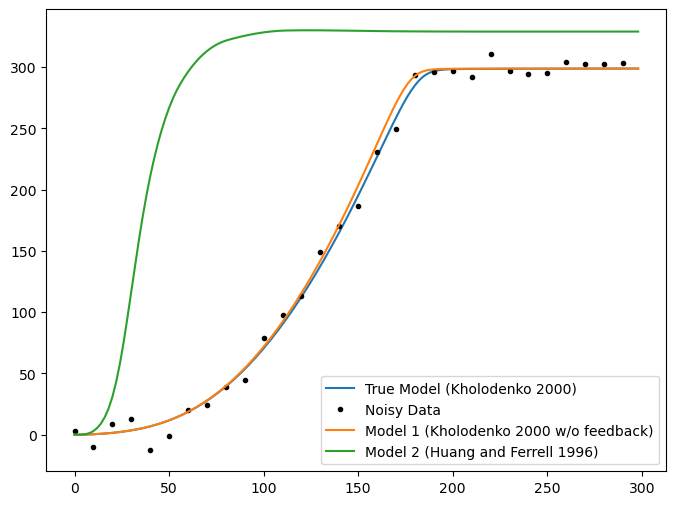

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.plot(sol_true.ts, sol_true.ys[-1], label='True Model (Kholodenko 2000)')
plt.plot(sub_time, sub_mapk_pp + noise, 'k.', label='Noisy Data')
plt.plot(sol_model_1.ts, sol_model_1.ys[-1], label='Model 1 (Kholodenko 2000 w/o feedback)')
plt.plot(sol_model_2.ts, sol_model_2.ys[-2]+sol_model_2.ys[-3]+sol_model_2.ys[-6], label='Model 2 (Huang and Ferrell 1996)')
plt.legend()